In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import wrf

In [2]:
def preprocess(f):
    
    time_strs = [str(i.values)[1:].replace("_"," ") for i in f.Times]
    time_datetime = pd.to_datetime(time_strs)
    f = f.assign(Time=time_datetime)
    
    return f
    

In [3]:
f = xr.open_mfdataset("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa/sfcwind_d04_2023-10-*",
                      decode_times=False,concat_dim="Time",combine="nested",preprocess=preprocess)
f["ws"] = np.sqrt(np.square(f["U10"]) + np.square(f["V10"]))
times = f.Time.values
wrflist = Dataset("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa/sfcwind_d04_2023-10-15_06:00:00")

0.3.0


In [4]:
f_shortlead = xr.open_mfdataset("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/sfcwind_d04_2023-10-*",
                      decode_times=False,concat_dim="Time",combine="nested",preprocess=preprocess)
f_shortlead["ws"] = np.sqrt(np.square(f_shortlead["U10"]) + np.square(f_shortlead["V10"]))
times_shortlead = f_shortlead.Time.values
wrflist_shortlead = Dataset("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/sfcwind_d04_2023-10-15_15:00:00")

In [5]:
f_medlead = xr.open_mfdataset("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_medlead/sfcwind_d04_2023-10-*",
                      decode_times=False,concat_dim="Time",combine="nested",preprocess=preprocess)
f_medlead["ws"] = np.sqrt(np.square(f_medlead["U10"]) + np.square(f_medlead["V10"]))
times_medlead = f_medlead.Time.values
wrflist_medlead = Dataset("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_medlead/sfcwind_d04_2023-10-15_15:00:00")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ... 

In [6]:
#From the underway data directory, load navigation info
underway_data_path = "/g/data/w40/ab4502/IN2023_V06/data/underway/"
fnames = ["20231014-213337-shipnav-shipnav_01.nav","20231015-093337-shipnav-shipnav_01.nav","20231015-213338-shipnav-shipnav_01.nav"]
underway_nav = xr.open_mfdataset([underway_data_path+s for s in fnames])[["lat","long"]]

#Extract ship lat/lon at WRF output times
ship_lons = []
ship_lats = []
for t in tqdm.tqdm(range(times.shape[0])):
    current_nav = underway_nav.sel(time=times[t],method="nearest")
    ship_lat, ship_lon = current_nav.lat.values, current_nav.long.values
    ship_lats.append(float(ship_lat))
    ship_lons.append(float(ship_lon))
    
ship_lons_shortlead = []
ship_lats_shortlead = []
for t in tqdm.tqdm(range(times_shortlead.shape[0])):
    current_nav = underway_nav.sel(time=times_shortlead[t],method="nearest")
    ship_lat, ship_lon = current_nav.lat.values, current_nav.long.values
    ship_lats_shortlead.append(float(ship_lat))
    ship_lons_shortlead.append(float(ship_lon))
    
ship_lons_medlead = []
ship_lats_medlead = []
for t in tqdm.tqdm(range(times_medlead.shape[0])):
    current_nav = underway_nav.sel(time=times_medlead[t],method="nearest")
    ship_lat, ship_lon = current_nav.lat.values, current_nav.long.values
    ship_lats_medlead.append(float(ship_lat))
    ship_lons_medlead.append(float(ship_lon))    

100%|██████████| 1455/1455 [00:04<00:00, 343.99it/s]


In [7]:
ship_x, ship_y = wrf.ll_to_xy(wrflist,ship_lats,ship_lons).values
target_x = xr.DataArray(ship_x,dims="points")
target_y = xr.DataArray(ship_y,dims="points")
ws_points = f.sel(south_north=target_y, west_east=target_x).ws.values

ship_x_shortlead, ship_y_shortlead = wrf.ll_to_xy(wrflist_shortlead,ship_lats_shortlead,ship_lons_shortlead).values
target_x_shortlead = xr.DataArray(ship_x_shortlead,dims="points")
target_y_shortlead = xr.DataArray(ship_y_shortlead,dims="points")
ws_points_shortlead = f_shortlead.sel(south_north=target_y_shortlead, west_east=target_x_shortlead).ws.values

ship_x_medlead, ship_y_medlead = wrf.ll_to_xy(wrflist_medlead,ship_lats_medlead,ship_lons_medlead).values
target_x_medlead = xr.DataArray(ship_x_medlead,dims="points")
target_y_medlead = xr.DataArray(ship_y_medlead,dims="points")
ws_points_medlead = f_medlead.sel(south_north=target_y_medlead, west_east=target_x_medlead).ws.values

In [8]:
def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)

        R = 6373.0

        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)

wrf_lats = f["XLAT"].isel(Time=0).values
wrf_lons = f["XLONG"].isel(Time=0).values
dist = np.stack([latlon_dist(ship_lats[i], ship_lons[i], wrf_lats, wrf_lons) for i in tqdm.tqdm(range(len(ship_lats)))])

wrf_lats_shortlead = f_shortlead["XLAT"].isel(Time=0).values
wrf_lons_shortlead = f_shortlead["XLONG"].isel(Time=0).values
dist_shortlead = np.stack([latlon_dist(ship_lats_shortlead[i], ship_lons_shortlead[i], wrf_lats_shortlead, wrf_lons_shortlead) for i in tqdm.tqdm(range(len(ship_lats_shortlead)))])

wrf_lats_medlead = f_medlead["XLAT"].isel(Time=0).values
wrf_lons_medlead = f_medlead["XLONG"].isel(Time=0).values
dist_medlead = np.stack([latlon_dist(ship_lats_medlead[i], ship_lons_medlead[i], wrf_lats_medlead, wrf_lons_medlead) for i in tqdm.tqdm(range(len(ship_lats_medlead)))])


100%|██████████| 1455/1455 [00:17<00:00, 83.07it/s]


In [9]:
ws_mask = f["ws"].where(dist<=100,np.nan)
ws_mask_shortlead = f_shortlead["ws"].where(dist_shortlead<=100,np.nan)
ws_mask_medlead = f_medlead["ws"].where(dist_medlead<=100,np.nan)

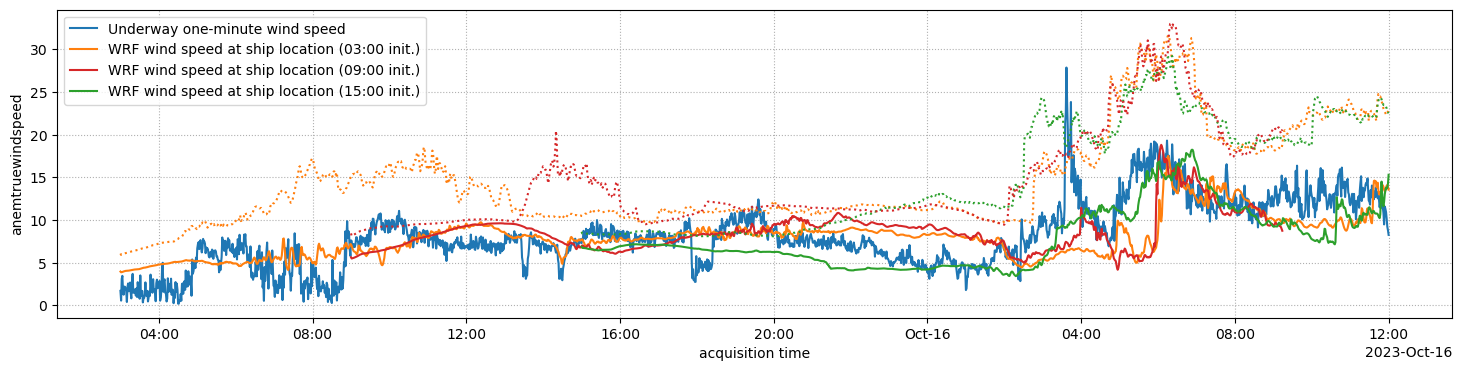

In [10]:
plt.figure(figsize=[18,4])

fnames = ["20231014-213339-weather-met_01.met","20231015-093340-weather-met_01.met","20231015-213339-weather-met_01.met","20231016-093341-weather-met_01.met"]
underway_weather = xr.open_mfdataset([underway_data_path+s for s in fnames])
(underway_weather["anemtruewindspeed"]/1.94384).sel(time=times,method="nearest").plot(label="Underway one-minute wind speed")


plt.plot(times,[ws_points[t,t] for t in range(ws_points.shape[0])],label="WRF wind speed at ship location (03:00 init.)")
plt.plot(times_medlead,[ws_points_medlead[t,t] for t in range(ws_points_medlead.shape[0])],label="WRF wind speed at ship location (09:00 init.)",color="tab:red")
plt.plot(times_shortlead,[ws_points_shortlead[t,t] for t in range(ws_points_shortlead.shape[0])],label="WRF wind speed at ship location (15:00 init.)",color="tab:green")
plt.legend()

plt.plot(times,ws_mask.max(("south_north","west_east")).values,label="WRF wind speed, 100 km radius (03:00 init.)",ls=":",color="tab:orange")
plt.plot(times_shortlead,ws_mask_shortlead.max(("south_north","west_east")).values,label="WRF wind speed, 100 km radius (15:00 init.)",ls=":",color="tab:green")
plt.plot(times_medlead,ws_mask_medlead.max(("south_north","west_east")).values,label="WRF wind speed, 100 km radius (09:00 init.)",ls=":",color="tab:red")

plt.gca().grid(ls=":")

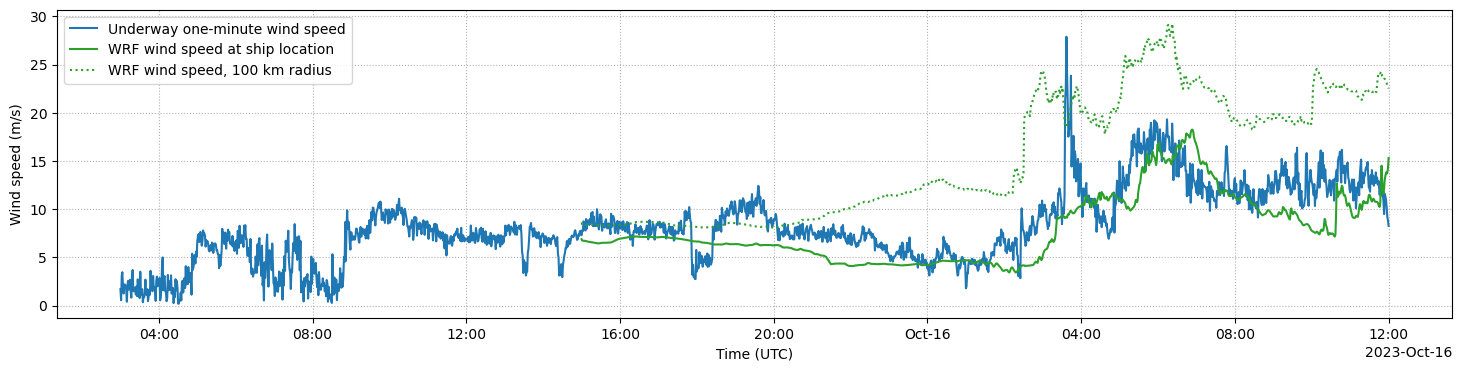

In [9]:
plt.figure(figsize=[18,4])

fnames = ["20231014-213339-weather-met_01.met","20231015-093340-weather-met_01.met","20231015-213339-weather-met_01.met","20231016-093341-weather-met_01.met"]
underway_weather = xr.open_mfdataset([underway_data_path+s for s in fnames])
(underway_weather["anemtruewindspeed"]/1.94384).sel(time=times,method="nearest").plot(label="Underway one-minute wind speed")


plt.plot(times_shortlead,[ws_points_shortlead[t,t] for t in range(ws_points_shortlead.shape[0])],label="WRF wind speed at ship location",color="tab:green")
plt.plot(times_shortlead,ws_mask_shortlead.max(("south_north","west_east")).values,label="WRF wind speed, 100 km radius",ls=":",color="tab:green")
plt.legend()

plt.gca().grid(ls=":")

plt.ylabel("Wind speed (m/s)")
plt.xlabel("Time (UTC)")

plt.savefig("/g/data/w40/ab4502/IN2023_V06/figs/wrf_wind_timeseries.jpeg",dpi=400,bbox_inches="tight")

19.968573


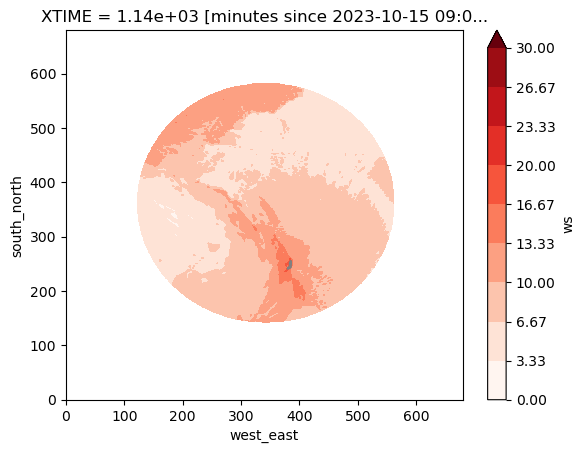

In [18]:
t="2023-10-16 04:00"
ws_mask_medlead = f_medlead["ws"].where(dist_medlead<=100,np.nan)
xr.plot.contourf(ws_mask_medlead.sel(Time=t),cmap=plt.get_cmap("Reds"),levels=np.linspace(0,30,10),extend="max")
xr.plot.contour(ws_mask_medlead.sel(Time=t),colors=["k","grey"],levels=[18])

print(np.nanmax(ws_mask_medlead.sel(Time=t).values))